In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sn

In [4]:
# !wget https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
# !unzip gsn-2021-1.zip &> /dev/null
# !rm gsn-2021-1.zip

--2021-05-03 10:49:27--  https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
Resolving www.mimuw.edu.pl (www.mimuw.edu.pl)... 193.0.96.14
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘gsn-2021-1.zip’

gsn-2021-1.zip      100%[===================>]   5.29M  3.80MB/s    in 1.4s    

2021-05-03 10:49:30 (3.80 MB/s) - ‘gsn-2021-1.zip’ saved [5544261/5544261]



In [5]:
class FiguresDataset(Dataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, train, transform=None):
        self.figures_frame = pd.read_csv(csv_file)
        if train:
            self.figures_frame = self.figures_frame[:9000]
        else:
            self.figures_frame = self.figures_frame[-1000:]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.figures_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.figures_frame.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True);
        figures = self.figures_frame.iloc[idx, 1:]
        figures = np.array(figures)
        figures = figures.astype('int')
        sample = (image, figures)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        image, figures = sample
        
        return (torch.from_numpy(image).float(), torch.from_numpy(figures))
    
class ToProbs(object):
    def __call__(self, sample):
        image, figures = sample
        
        return (image, torch.where(figures > 0., 1., 0.))
    
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, figures = sample
        
        norm = transforms.Normalize(self.mean, self.std)
        image = norm(image.unsqueeze_(2)).squeeze_(2)
        
        return (image, figures)

class HorizontalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.hflip(image)
        figures[3], figures[5] = figures[5].clone(), figures[3].clone()
        
        return (image, figures)

class VerticalFlip(object):
    def __call__(self, sample):
        image, figures = sample
        
        image = transforms.functional.vflip(image)
        figures[2], figures[4] = figures[4].clone(), figures[2].clone() 
        
        return (image, figures)
    
class Rotate(object):
    def __init__(self):
        self.ks = [1, 2, 3]
        
    def __call__(self, sample):
        image, figures = sample
        
        k = int(np.random.choice(self.ks))        
        image = torch.rot90(image, k)
        figures[2:] = torch.roll(figures[2:], -k)
        
        return (image, figures)

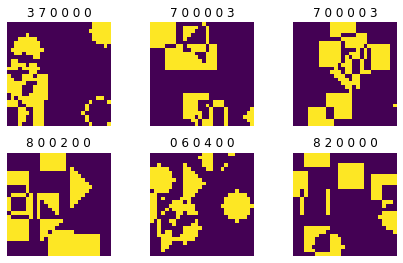

In [7]:
from random import randint

csv_file = csv_file='data/labels.csv'
root_dir = 'data/'
figures_dataset = FiguresDataset(csv_file, root_dir, train=True)

fig = plt.figure()

for i in range(6):
    r = randint(0, len(figures_dataset))
    image, figures = figures_dataset[r]

    
    ax = plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    ax.set_title(' '.join(map(str, figures)))
    ax.axis('off')
    
    plt.imshow(image)

plt.subplots_adjust()
plt.show()

In [8]:
torch.manual_seed(1)
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if device == 'cuda':
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    


transform = transforms.Compose([ToTensor(), ToProbs(), Normalize(mean=0.5, std=0.5)])

train_dataset = FiguresDataset(csv_file, root_dir, True, transforms.Compose([transform, transforms.RandomChoice([Rotate(), VerticalFlip(), HorizontalFlip()])]))
test_dataset = FiguresDataset(csv_file, root_dir, False, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [10]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=.00001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.stop = False
        
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss > self.min_delta:
            self.best_loss = loss
        elif self.best_loss - loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
    

In [11]:
def predict(output):
    indices = torch.topk(output, k=2, dim=1)[1]
    return torch.zeros_like(output).scatter_(1, indices, 1)

def eval_metric(pred, target):
    return torch.sum(torch.all(torch.eq(pred, target), dim=1))

def train(model, device, train_loader, optimizer, log=False):
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        train_loss += loss.item()
        pred = predict(output)
        correct += eval_metric(pred, target).item()
        loss.backward()
        optimizer.step()
        
        if log and batch_idx % 10 == 0:
            print('Train Batch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy(output, target).item()  # sum up batch loss
            pred = predict(output)
            correct += eval_metric(pred, target).item()
            preds.extend(pred)
            targets.extend(target)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy, preds, targets

def prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    l1, = ax1.plot(train_loss, color='b', label="Train")
    l2, = ax1.plot(test_loss, color='r', label='Test')
    ax1.set_title('Losses')
    ax2.plot(train_accuracy, color='b', label="Train")
    ax2.plot(test_accuracy, color='r', label='Test')
    ax2.set_title('Accuracies')
    plt.legend([l1, l2], ["Train", "Test"])

    plt.show()

def prep_confusion_matrix(preds, targets):
    labels = ['down+left', 'right+left', 'right+down', 'up+left', 'up+down', 'up+right', 'circles+left', 'circles+down', 'circles+right', 'circles+up', 'squares+left', 'squares+down', 'squares+right', 'squares+up', 'squares+circles']
    y_act = pd.Series(list(map(lambda x: str(x.tolist()), targets)), name='Actual')
    y_pred = pd.Series(list(map(lambda x: str(x.tolist()), preds)), name='Predicted')
    df_confusion = pd.crosstab(y_act, y_pred)
    
    sn.heatmap(df_confusion, annot=True, xticklabels=labels, yticklabels=labels, cbar=False, cmap="YlGnBu")
    plt.show()
    

def train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping=None):
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []
    
    for epoch in range(1, epochs + 1):
        print("\nEpoch: {}/{}\n".format(epoch, epochs))
        train_loss_epoch, train_accuracy_epoch = train(model, device, train_loader, optimizer)
        test_loss_epoch, test_accuracy_epoch, preds, targets  = test(model, device, test_loader)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_accuracy_epoch)
        test_loss.append(test_loss_epoch)
        test_accuracy.append(test_accuracy_epoch)
        
        print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(train_loss_epoch, train_accuracy_epoch))
        print('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_epoch, test_accuracy_epoch))
        
        if not early_stopping == None:
            early_stopping(train_loss_epoch)
            if early_stopping.stop:
                print("Early stopped.")
                break
                
    prep_diagram(train_loss, train_accuracy, test_loss, test_accuracy)
    prep_confusion_matrix(preds, targets)
    

In [12]:
class Conv5Lin1(nn.Module):
    def __init__(self):
        super(Conv5Lin1, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0107, Accuracy: 14%
Test set: Average loss: 0.0006, Accuracy: 24%

Epoch: 2/40

Train set: Average loss: 0.0091, Accuracy: 35%
Test set: Average loss: 0.0005, Accuracy: 49%

Epoch: 3/40

Train set: Average loss: 0.0078, Accuracy: 61%
Test set: Average loss: 0.0005, Accuracy: 71%

Epoch: 4/40

Train set: Average loss: 0.0075, Accuracy: 73%
Test set: Average loss: 0.0005, Accuracy: 73%

Epoch: 5/40

Train set: Average loss: 0.0073, Accuracy: 77%
Test set: Average loss: 0.0005, Accuracy: 78%

Epoch: 6/40

Train set: Average loss: 0.0073, Accuracy: 78%
Test set: Average loss: 0.0005, Accuracy: 77%

Epoch: 7/40

Train set: Average loss: 0.0071, Accuracy: 80%
Test set: Average loss: 0.0005, Accuracy: 79%

Epoch: 8/40

Train set: Average loss: 0.0071, Accuracy: 80%
Test set: Average loss: 0.0005, Accuracy: 79%

Epoch: 9/40

Train set: Average loss: 0.0070, Accuracy: 81%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 10/40

Train set: Average los

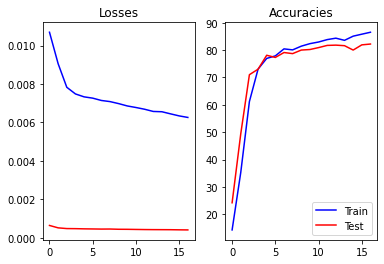

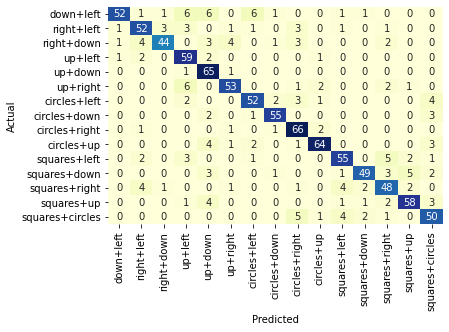

In [13]:
model = Conv5Lin1().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2(nn.Module):
    def __init__(self):
        super(Conv5Lin2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0107, Accuracy: 14%
Test set: Average loss: 0.0006, Accuracy: 27%

Epoch: 2/40

Train set: Average loss: 0.0093, Accuracy: 30%
Test set: Average loss: 0.0006, Accuracy: 37%

Epoch: 3/40

Train set: Average loss: 0.0089, Accuracy: 38%
Test set: Average loss: 0.0006, Accuracy: 38%

Epoch: 4/40

Train set: Average loss: 0.0085, Accuracy: 43%
Test set: Average loss: 0.0005, Accuracy: 46%

Epoch: 5/40

Train set: Average loss: 0.0079, Accuracy: 51%
Test set: Average loss: 0.0005, Accuracy: 56%

Epoch: 6/40

Train set: Average loss: 0.0073, Accuracy: 61%
Test set: Average loss: 0.0005, Accuracy: 64%

Epoch: 7/40

Train set: Average loss: 0.0066, Accuracy: 71%
Test set: Average loss: 0.0004, Accuracy: 74%

Epoch: 8/40

Train set: Average loss: 0.0061, Accuracy: 77%
Test set: Average loss: 0.0004, Accuracy: 72%

Epoch: 9/40

Train set: Average loss: 0.0059, Accuracy: 80%
Test set: Average loss: 0.0004, Accuracy: 79%

Epoch: 10/40

Train set: Average los

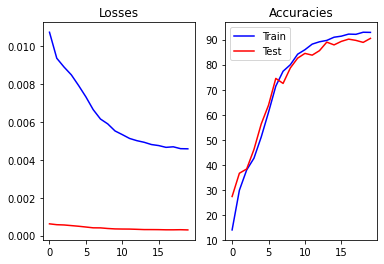

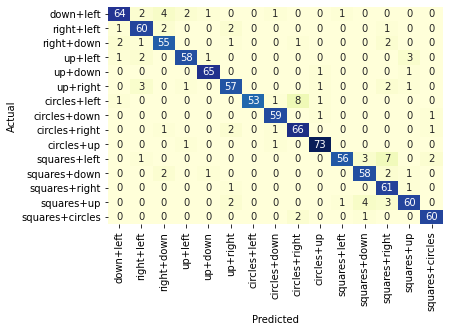

In [ ]:
model = Conv5Lin2().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv6Lin2(nn.Module):
    def __init__(self):
        super(Conv6Lin2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0110, Accuracy: 11%
Test set: Average loss: 0.0007, Accuracy: 14%

Epoch: 2/40

Train set: Average loss: 0.0094, Accuracy: 29%
Test set: Average loss: 0.0005, Accuracy: 40%

Epoch: 3/40

Train set: Average loss: 0.0081, Accuracy: 45%
Test set: Average loss: 0.0005, Accuracy: 62%

Epoch: 4/40

Train set: Average loss: 0.0069, Accuracy: 68%
Test set: Average loss: 0.0004, Accuracy: 75%

Epoch: 5/40

Train set: Average loss: 0.0060, Accuracy: 79%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 6/40

Train set: Average loss: 0.0055, Accuracy: 84%
Test set: Average loss: 0.0004, Accuracy: 84%

Epoch: 7/40

Train set: Average loss: 0.0052, Accuracy: 87%
Test set: Average loss: 0.0003, Accuracy: 86%

Epoch: 8/40

Train set: Average loss: 0.0050, Accuracy: 89%
Test set: Average loss: 0.0003, Accuracy: 88%

Epoch: 9/40

Train set: Average loss: 0.0049, Accuracy: 90%
Test set: Average loss: 0.0003, Accuracy: 89%

Epoch: 10/40

Train set: Average los

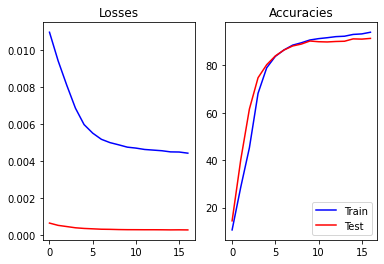

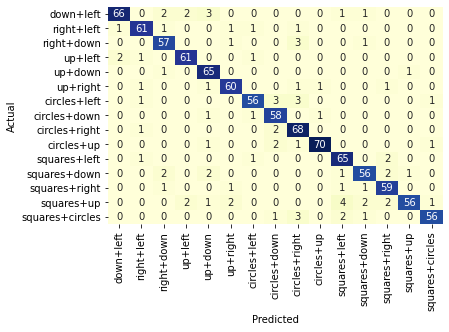

In [ ]:
model = Conv6Lin2().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv7Lin2(nn.Module):
    def __init__(self):
        super(Conv7Lin2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(512 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0112, Accuracy: 8%
Test set: Average loss: 0.0007, Accuracy: 15%

Epoch: 2/40

Train set: Average loss: 0.0101, Accuracy: 19%
Test set: Average loss: 0.0006, Accuracy: 22%

Epoch: 3/40

Train set: Average loss: 0.0089, Accuracy: 31%
Test set: Average loss: 0.0005, Accuracy: 35%

Epoch: 4/40

Train set: Average loss: 0.0083, Accuracy: 38%
Test set: Average loss: 0.0005, Accuracy: 40%

Epoch: 5/40

Train set: Average loss: 0.0076, Accuracy: 48%
Test set: Average loss: 0.0005, Accuracy: 51%

Epoch: 6/40

Train set: Average loss: 0.0069, Accuracy: 58%
Test set: Average loss: 0.0004, Accuracy: 58%

Epoch: 7/40

Train set: Average loss: 0.0065, Accuracy: 65%
Test set: Average loss: 0.0004, Accuracy: 70%

Epoch: 8/40

Train set: Average loss: 0.0059, Accuracy: 79%
Test set: Average loss: 0.0004, Accuracy: 81%

Epoch: 9/40

Train set: Average loss: 0.0054, Accuracy: 85%
Test set: Average loss: 0.0004, Accuracy: 83%

Epoch: 10/40

Train set: Average loss

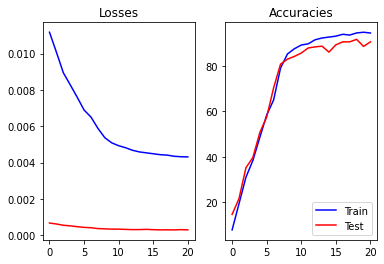

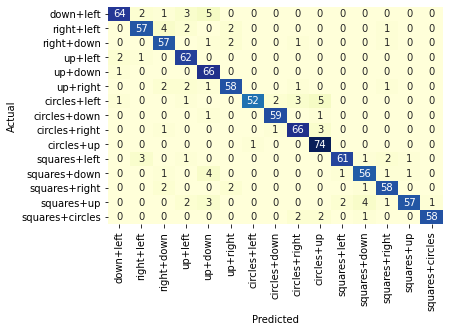

In [ ]:
model = Conv7Lin2().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2Drop(nn.Module):
    def __init__(self):
        super(Conv5Lin2Drop, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0111, Accuracy: 9%
Test set: Average loss: 0.0007, Accuracy: 14%

Epoch: 2/40

Train set: Average loss: 0.0101, Accuracy: 21%
Test set: Average loss: 0.0006, Accuracy: 29%

Epoch: 3/40

Train set: Average loss: 0.0094, Accuracy: 29%
Test set: Average loss: 0.0006, Accuracy: 34%

Epoch: 4/40

Train set: Average loss: 0.0089, Accuracy: 37%
Test set: Average loss: 0.0005, Accuracy: 47%

Epoch: 5/40

Train set: Average loss: 0.0082, Accuracy: 47%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 6/40

Train set: Average loss: 0.0079, Accuracy: 53%
Test set: Average loss: 0.0005, Accuracy: 59%

Epoch: 7/40

Train set: Average loss: 0.0076, Accuracy: 57%
Test set: Average loss: 0.0005, Accuracy: 66%

Epoch: 8/40

Train set: Average loss: 0.0073, Accuracy: 63%
Test set: Average loss: 0.0004, Accuracy: 78%

Epoch: 9/40

Train set: Average loss: 0.0070, Accuracy: 71%
Test set: Average loss: 0.0004, Accuracy: 81%

Epoch: 10/40

Train set: Average loss

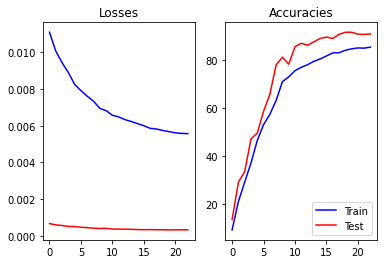

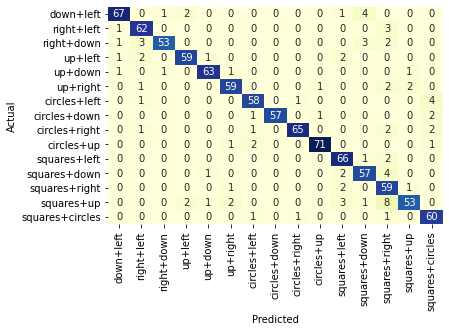

In [ ]:
model = Conv5Lin2Drop().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2DropFull(nn.Module):
    def __init__(self):
        super(Conv5Lin2DropFull, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0112, Accuracy: 8%
Test set: Average loss: 0.0007, Accuracy: 11%

Epoch: 2/40

Train set: Average loss: 0.0108, Accuracy: 12%
Test set: Average loss: 0.0007, Accuracy: 13%

Epoch: 3/40

Train set: Average loss: 0.0103, Accuracy: 15%
Test set: Average loss: 0.0006, Accuracy: 21%

Epoch: 4/40

Train set: Average loss: 0.0095, Accuracy: 25%
Test set: Average loss: 0.0006, Accuracy: 30%

Epoch: 5/40

Train set: Average loss: 0.0088, Accuracy: 35%
Test set: Average loss: 0.0005, Accuracy: 41%

Epoch: 6/40

Train set: Average loss: 0.0083, Accuracy: 42%
Test set: Average loss: 0.0005, Accuracy: 46%

Epoch: 7/40

Train set: Average loss: 0.0081, Accuracy: 46%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 8/40

Train set: Average loss: 0.0079, Accuracy: 48%
Test set: Average loss: 0.0005, Accuracy: 51%

Epoch: 9/40

Train set: Average loss: 0.0079, Accuracy: 48%
Test set: Average loss: 0.0005, Accuracy: 56%

Epoch: 10/40

Train set: Average loss

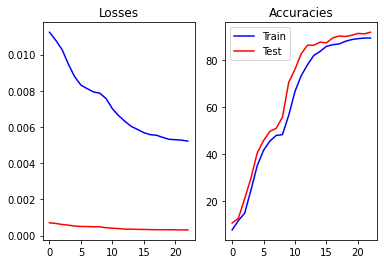

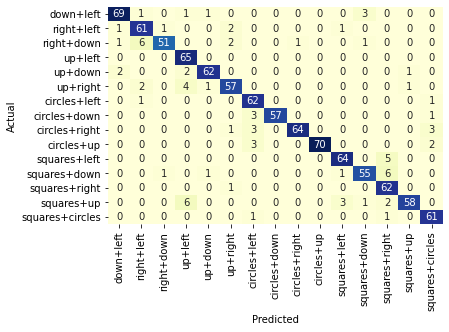

In [ ]:
model = Conv5Lin2DropFull().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2BN(nn.Module):
    def __init__(self):
        super(Conv5Lin2BN, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 18 * 18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0079, Accuracy: 59%
Test set: Average loss: 0.0005, Accuracy: 54%

Epoch: 2/40

Train set: Average loss: 0.0060, Accuracy: 82%
Test set: Average loss: 0.0004, Accuracy: 66%

Epoch: 3/40

Train set: Average loss: 0.0055, Accuracy: 87%
Test set: Average loss: 0.0004, Accuracy: 86%

Epoch: 4/40

Train set: Average loss: 0.0051, Accuracy: 89%
Test set: Average loss: 0.0004, Accuracy: 76%

Epoch: 5/40

Train set: Average loss: 0.0049, Accuracy: 92%
Test set: Average loss: 0.0003, Accuracy: 87%

Epoch: 6/40

Train set: Average loss: 0.0048, Accuracy: 92%
Test set: Average loss: 0.0003, Accuracy: 89%

Epoch: 7/40

Train set: Average loss: 0.0046, Accuracy: 94%
Test set: Average loss: 0.0004, Accuracy: 76%

Epoch: 8/40

Train set: Average loss: 0.0045, Accuracy: 94%
Test set: Average loss: 0.0003, Accuracy: 92%

Epoch: 9/40

Train set: Average loss: 0.0045, Accuracy: 95%
Test set: Average loss: 0.0003, Accuracy: 90%

Epoch: 10/40

Train set: Average los

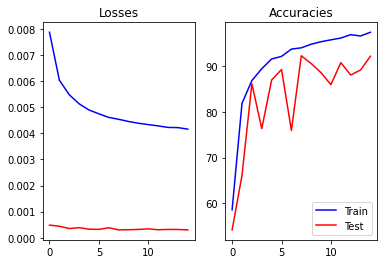

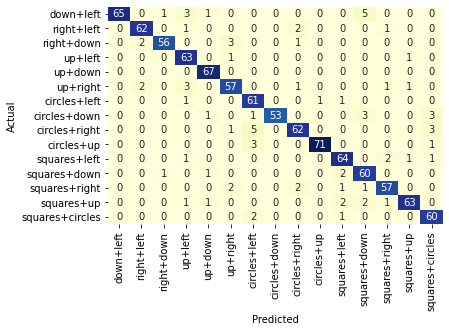

In [ ]:
model = Conv5Lin2BN().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/40

Train set: Average loss: 0.0082, Accuracy: 52%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 2/40

Train set: Average loss: 0.0059, Accuracy: 80%
Test set: Average loss: 0.0004, Accuracy: 66%

Epoch: 3/40

Train set: Average loss: 0.0053, Accuracy: 86%
Test set: Average loss: 0.0003, Accuracy: 84%

Epoch: 4/40

Train set: Average loss: 0.0049, Accuracy: 90%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 5/40

Train set: Average loss: 0.0048, Accuracy: 92%
Test set: Average loss: 0.0003, Accuracy: 90%

Epoch: 6/40

Train set: Average loss: 0.0046, Accuracy: 93%
Test set: Average loss: 0.0003, Accuracy: 91%

Epoch: 7/40

Train set: Average loss: 0.0045, Accuracy: 93%
Test set: Average loss: 0.0003, Accuracy: 92%

Epoch: 8/40

Train set: Average loss: 0.0045, Accuracy: 94%
Test set: Average loss: 0.0003, Accuracy: 92%

Epoch: 9/40

Train set: Average loss: 0.0044, Accuracy: 95%
Test set: Average loss: 0.0003, Accuracy: 93%

Epoch: 10/40

Train set: Average los

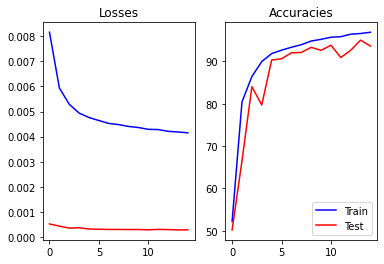

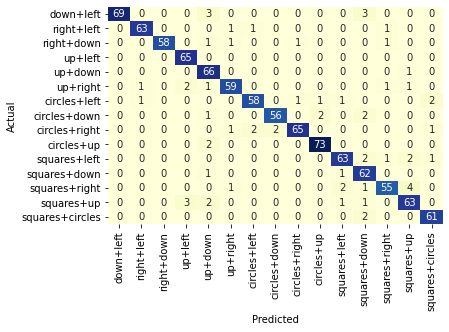

In [ ]:
model = Conv5Lin2BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2Pool1(nn.Module): 
    def __init__(self):
        super(Conv5Lin2Pool1, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0106, Accuracy: 16%
Test set: Average loss: 0.0006, Accuracy: 32%

Epoch: 2/40

Train set: Average loss: 0.0091, Accuracy: 36%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 3/40

Train set: Average loss: 0.0079, Accuracy: 54%
Test set: Average loss: 0.0005, Accuracy: 53%

Epoch: 4/40

Train set: Average loss: 0.0073, Accuracy: 63%
Test set: Average loss: 0.0005, Accuracy: 64%

Epoch: 5/40

Train set: Average loss: 0.0067, Accuracy: 70%
Test set: Average loss: 0.0004, Accuracy: 67%

Epoch: 6/40

Train set: Average loss: 0.0063, Accuracy: 74%
Test set: Average loss: 0.0004, Accuracy: 74%

Epoch: 7/40

Train set: Average loss: 0.0060, Accuracy: 77%
Test set: Average loss: 0.0004, Accuracy: 71%

Epoch: 8/40

Train set: Average loss: 0.0058, Accuracy: 79%
Test set: Average loss: 0.0004, Accuracy: 79%

Epoch: 9/40

Train set: Average loss: 0.0056, Accuracy: 81%
Test set: Average loss: 0.0004, Accuracy: 81%

Epoch: 10/40

Train set: Average los

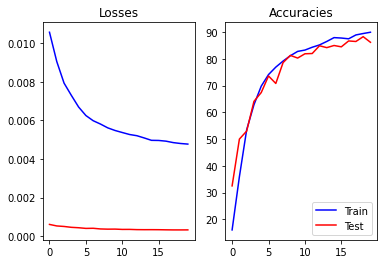

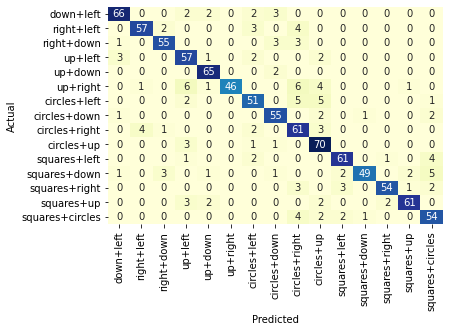

In [ ]:
model = Conv5Lin2Pool1().to(device)
optimizer = optim.Adam(model.parameters())
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)


Epoch: 1/40

Train set: Average loss: 0.0113, Accuracy: 7%
Test set: Average loss: 0.0007, Accuracy: 9%

Epoch: 2/40

Train set: Average loss: 0.0112, Accuracy: 9%
Test set: Average loss: 0.0007, Accuracy: 11%

Epoch: 3/40

Train set: Average loss: 0.0104, Accuracy: 15%
Test set: Average loss: 0.0007, Accuracy: 18%

Epoch: 4/40

Train set: Average loss: 0.0100, Accuracy: 20%
Test set: Average loss: 0.0006, Accuracy: 22%

Epoch: 5/40

Train set: Average loss: 0.0096, Accuracy: 27%
Test set: Average loss: 0.0006, Accuracy: 32%

Epoch: 6/40

Train set: Average loss: 0.0090, Accuracy: 35%
Test set: Average loss: 0.0006, Accuracy: 36%

Epoch: 7/40

Train set: Average loss: 0.0084, Accuracy: 43%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 8/40

Train set: Average loss: 0.0074, Accuracy: 57%
Test set: Average loss: 0.0004, Accuracy: 64%

Epoch: 9/40

Train set: Average loss: 0.0066, Accuracy: 70%
Test set: Average loss: 0.0004, Accuracy: 64%

Epoch: 10/40

Train set: Average loss: 

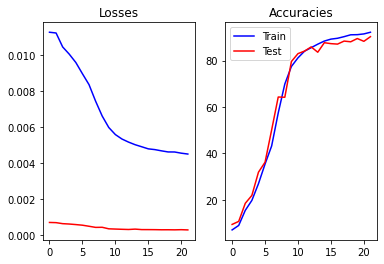

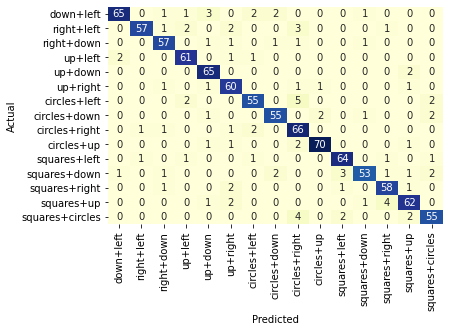

In [ ]:
model = Conv5Lin2Pool1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2Pool2(nn.Module): 
    def __init__(self):
        super(Conv5Lin2Pool2, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 6 * 6, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0113, Accuracy: 7%
Test set: Average loss: 0.0007, Accuracy: 6%

Epoch: 2/40

Train set: Average loss: 0.0112, Accuracy: 8%
Test set: Average loss: 0.0007, Accuracy: 9%

Epoch: 3/40

Train set: Average loss: 0.0112, Accuracy: 9%
Test set: Average loss: 0.0007, Accuracy: 10%

Epoch: 4/40

Train set: Average loss: 0.0104, Accuracy: 17%
Test set: Average loss: 0.0006, Accuracy: 27%

Epoch: 5/40

Train set: Average loss: 0.0087, Accuracy: 39%
Test set: Average loss: 0.0005, Accuracy: 45%

Epoch: 6/40

Train set: Average loss: 0.0075, Accuracy: 58%
Test set: Average loss: 0.0004, Accuracy: 70%

Epoch: 7/40

Train set: Average loss: 0.0064, Accuracy: 74%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 8/40

Train set: Average loss: 0.0058, Accuracy: 80%
Test set: Average loss: 0.0003, Accuracy: 84%

Epoch: 9/40

Train set: Average loss: 0.0054, Accuracy: 85%
Test set: Average loss: 0.0003, Accuracy: 88%

Epoch: 10/40

Train set: Average loss: 0.

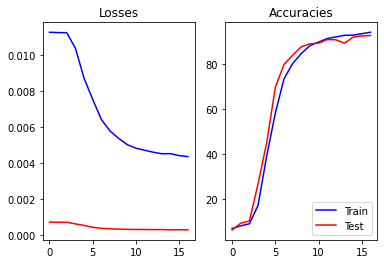

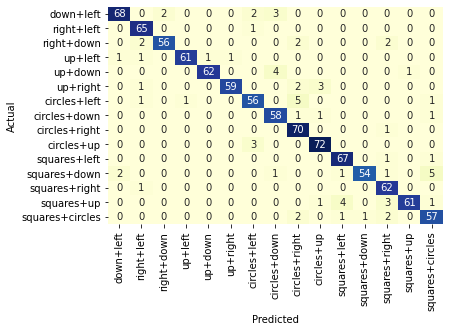

In [ ]:
model = Conv5Lin2Pool2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2Pool3(nn.Module): 
    def __init__(self):
        super(Conv5Lin2Pool3, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0113, Accuracy: 7%
Test set: Average loss: 0.0007, Accuracy: 8%

Epoch: 2/40

Train set: Average loss: 0.0112, Accuracy: 9%
Test set: Average loss: 0.0007, Accuracy: 14%

Epoch: 3/40

Train set: Average loss: 0.0100, Accuracy: 22%
Test set: Average loss: 0.0006, Accuracy: 30%

Epoch: 4/40

Train set: Average loss: 0.0088, Accuracy: 38%
Test set: Average loss: 0.0005, Accuracy: 43%

Epoch: 5/40

Train set: Average loss: 0.0079, Accuracy: 54%
Test set: Average loss: 0.0004, Accuracy: 70%

Epoch: 6/40

Train set: Average loss: 0.0065, Accuracy: 73%
Test set: Average loss: 0.0004, Accuracy: 77%

Epoch: 7/40

Train set: Average loss: 0.0059, Accuracy: 79%
Test set: Average loss: 0.0004, Accuracy: 82%

Epoch: 8/40

Train set: Average loss: 0.0054, Accuracy: 85%
Test set: Average loss: 0.0003, Accuracy: 84%

Epoch: 9/40

Train set: Average loss: 0.0051, Accuracy: 87%
Test set: Average loss: 0.0003, Accuracy: 87%

Epoch: 10/40

Train set: Average loss: 

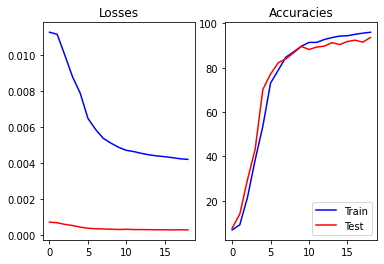

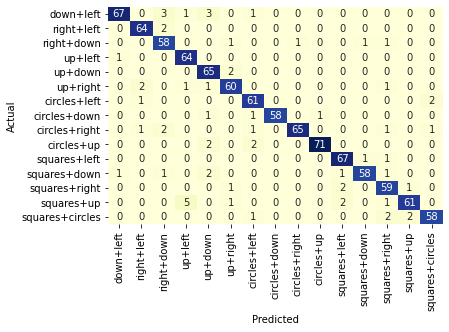

In [ ]:
model = Conv5Lin2Pool3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2Pool4(nn.Module): 
    def __init__(self):
        super(Conv5Lin2Pool4, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0113, Accuracy: 7%
Test set: Average loss: 0.0007, Accuracy: 8%

Epoch: 2/40

Train set: Average loss: 0.0112, Accuracy: 10%
Test set: Average loss: 0.0007, Accuracy: 13%

Epoch: 3/40

Train set: Average loss: 0.0105, Accuracy: 15%
Test set: Average loss: 0.0007, Accuracy: 15%

Epoch: 4/40

Train set: Average loss: 0.0100, Accuracy: 20%
Test set: Average loss: 0.0006, Accuracy: 20%

Epoch: 5/40

Train set: Average loss: 0.0092, Accuracy: 31%
Test set: Average loss: 0.0006, Accuracy: 36%

Epoch: 6/40

Train set: Average loss: 0.0083, Accuracy: 46%
Test set: Average loss: 0.0005, Accuracy: 50%

Epoch: 7/40

Train set: Average loss: 0.0073, Accuracy: 61%
Test set: Average loss: 0.0004, Accuracy: 66%

Epoch: 8/40

Train set: Average loss: 0.0065, Accuracy: 72%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 9/40

Train set: Average loss: 0.0059, Accuracy: 80%
Test set: Average loss: 0.0004, Accuracy: 82%

Epoch: 10/40

Train set: Average loss:

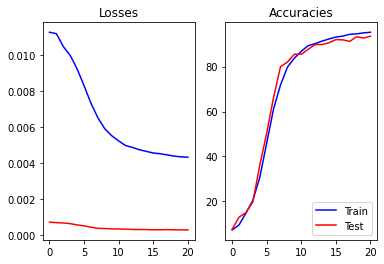

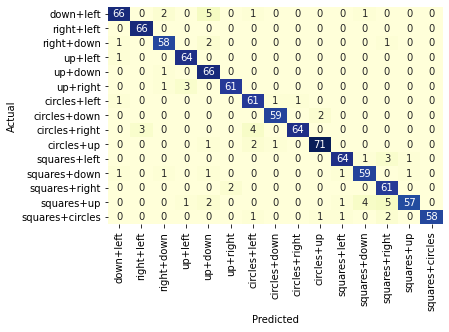

In [ ]:
model = Conv5Lin2Pool4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv5Lin2BNPool3(nn.Module):
    def __init__(self):
        super(Conv5Lin2BNPool3, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0080, Accuracy: 54%
Test set: Average loss: 0.0004, Accuracy: 66%

Epoch: 2/40

Train set: Average loss: 0.0059, Accuracy: 81%
Test set: Average loss: 0.0004, Accuracy: 70%

Epoch: 3/40

Train set: Average loss: 0.0053, Accuracy: 86%
Test set: Average loss: 0.0004, Accuracy: 78%

Epoch: 4/40

Train set: Average loss: 0.0049, Accuracy: 89%
Test set: Average loss: 0.0003, Accuracy: 82%

Epoch: 5/40

Train set: Average loss: 0.0047, Accuracy: 91%
Test set: Average loss: 0.0003, Accuracy: 88%

Epoch: 6/40

Train set: Average loss: 0.0046, Accuracy: 93%
Test set: Average loss: 0.0003, Accuracy: 92%

Epoch: 7/40

Train set: Average loss: 0.0045, Accuracy: 93%
Test set: Average loss: 0.0003, Accuracy: 90%

Epoch: 8/40

Train set: Average loss: 0.0044, Accuracy: 94%
Test set: Average loss: 0.0003, Accuracy: 92%

Epoch: 9/40

Train set: Average loss: 0.0044, Accuracy: 95%
Test set: Average loss: 0.0003, Accuracy: 91%

Epoch: 10/40

Train set: Average los

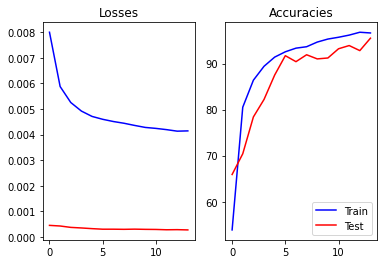

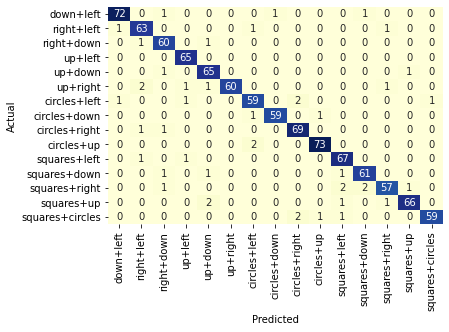

In [ ]:
model = Conv5Lin2BNPool3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv6Lin2BNPool3(nn.Module):
    def __init__(self):
        super(Conv6Lin2BNPool3, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 5 * 5, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0081, Accuracy: 50%
Test set: Average loss: 0.0005, Accuracy: 59%

Epoch: 2/40

Train set: Average loss: 0.0060, Accuracy: 78%
Test set: Average loss: 0.0004, Accuracy: 73%

Epoch: 3/40

Train set: Average loss: 0.0053, Accuracy: 85%
Test set: Average loss: 0.0004, Accuracy: 80%

Epoch: 4/40

Train set: Average loss: 0.0050, Accuracy: 88%
Test set: Average loss: 0.0003, Accuracy: 83%

Epoch: 5/40

Train set: Average loss: 0.0047, Accuracy: 90%
Test set: Average loss: 0.0003, Accuracy: 83%

Epoch: 6/40

Train set: Average loss: 0.0046, Accuracy: 92%
Test set: Average loss: 0.0003, Accuracy: 83%

Epoch: 7/40

Train set: Average loss: 0.0045, Accuracy: 93%
Test set: Average loss: 0.0003, Accuracy: 89%

Epoch: 8/40

Train set: Average loss: 0.0044, Accuracy: 94%
Test set: Average loss: 0.0003, Accuracy: 93%

Epoch: 9/40

Train set: Average loss: 0.0043, Accuracy: 94%
Test set: Average loss: 0.0003, Accuracy: 94%

Epoch: 10/40

Train set: Average los

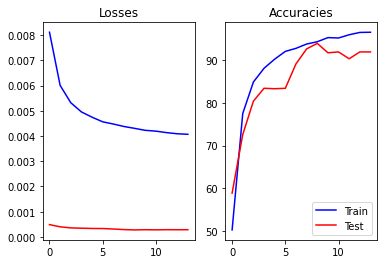

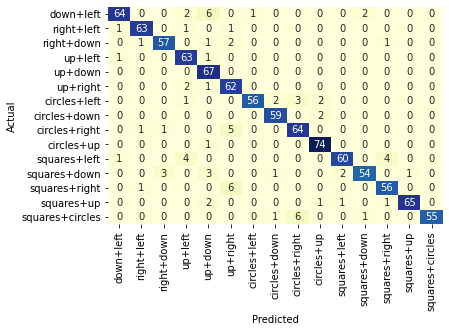

In [ ]:
model = Conv6Lin2BNPool3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)

In [ ]:
class Conv6Lin2BNDropFullPool3(nn.Module):
    def __init__(self):
        super(Conv6Lin2BNDropFullPool3, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 5 * 5, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.unsqueeze_(1)
        output = self.stack(x)
        return output


Epoch: 1/40

Train set: Average loss: 0.0101, Accuracy: 22%
Test set: Average loss: 0.0006, Accuracy: 38%

Epoch: 2/40

Train set: Average loss: 0.0082, Accuracy: 47%
Test set: Average loss: 0.0005, Accuracy: 51%

Epoch: 3/40

Train set: Average loss: 0.0070, Accuracy: 65%
Test set: Average loss: 0.0004, Accuracy: 68%

Epoch: 4/40

Train set: Average loss: 0.0063, Accuracy: 75%
Test set: Average loss: 0.0004, Accuracy: 83%

Epoch: 5/40

Train set: Average loss: 0.0058, Accuracy: 80%
Test set: Average loss: 0.0004, Accuracy: 74%

Epoch: 6/40

Train set: Average loss: 0.0055, Accuracy: 83%
Test set: Average loss: 0.0004, Accuracy: 78%

Epoch: 7/40

Train set: Average loss: 0.0053, Accuracy: 85%
Test set: Average loss: 0.0004, Accuracy: 81%

Epoch: 8/40

Train set: Average loss: 0.0052, Accuracy: 86%
Test set: Average loss: 0.0004, Accuracy: 81%

Epoch: 9/40

Train set: Average loss: 0.0051, Accuracy: 88%
Test set: Average loss: 0.0003, Accuracy: 86%

Epoch: 10/40

Train set: Average los

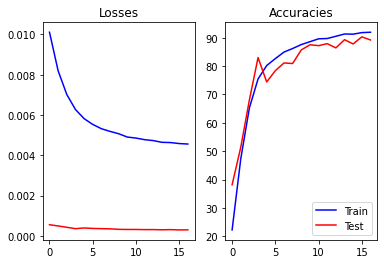

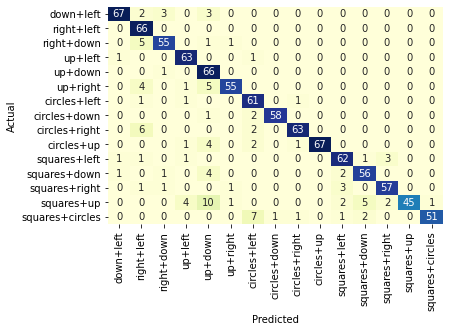

In [ ]:
model = Conv6Lin2BNDropFullPool3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
early_stopping = EarlyStopping(patience=5, min_delta=.0001)
epochs = 40

train_loop(model, device, train_loader, test_loader, optimizer, epochs, early_stopping)